# Sampling for FaIR

This notebook generates the parameter sets to run FaIR with for AR6 setups. This will be used in chapter 7 WG1 and passed on also to WG3 through `openscm-runner`

In [1]:
import errno
import fair
import json
import sys
import os
import random
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as pl
import pandas as pd
import pickle
from multiprocessing import Pool

from netCDF4 import Dataset
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from fair.constants import molwt
from fair.ancil import natural, cmip6_volcanic, cmip6_solar
from ar6.forcing.aerosol import ghan

In [2]:
fair.__version__

'1.6.2'

## Ensemble generation

We want to ensure reproducible results that don't change when this script is re-run. Grab list of pre-generated random seeds.

In [4]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [5]:
SAMPLES = 1000000
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)
F2XCO2_MEAN = 4.00
F2XCO2_NINETY = 0.48

## Thermal parameters

In [8]:
with open("../data_input/tunings/cmip6_twolayer_tuning_params.json", "r") as read_file:
    params = json.load(read_file)
cmip6_models = list(params['q4x']['model_data']['EBM-epsilon'].keys())
cmip6_models
NMODELS = len(cmip6_models)

geoff_data = np.zeros((NMODELS, 6))
for im, model in enumerate(cmip6_models):
    geoff_data[im,0] = params['q4x']['model_data']['EBM-epsilon'][model]
    geoff_data[im,1] = params['lamg']['model_data']['EBM-epsilon'][model]
    geoff_data[im,2] = params['cmix']['model_data']['EBM-epsilon'][model]
    geoff_data[im,3] = params['cdeep']['model_data']['EBM-epsilon'][model]
    geoff_data[im,4] = params['gamma_2l']['model_data']['EBM-epsilon'][model]
    geoff_data[im,5] = params['eff']['model_data']['EBM-epsilon'][model]

geoff_df = pd.DataFrame(geoff_data, columns=['q4x','lamg','cmix','cdeep','gamma_2l','eff'], index=cmip6_models)
kde = st.gaussian_kde(geoff_df.T)
geoff_sample = kde.resample(size=int(SAMPLES*1.25), seed = SEEDS[15])

# remove unphysical combinations
geoff_sample[:,geoff_sample[0,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[1,:] >= -0.55] = np.nan
geoff_sample[:,geoff_sample[2,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[3,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[4,:] <= 0] = np.nan
geoff_sample[:,geoff_sample[5,:] <= 0] = np.nan

mask = np.all(np.isnan(geoff_sample), axis=0)
geoff_sample = geoff_sample[:,~mask][:,:SAMPLES]
geoff_sample_df=pd.DataFrame(data=geoff_sample.T, columns=['q4x','lamg','cmix','cdeep','gamma_2l','eff'])
geoff_sample_df.to_csv('../data_output_large/geoff_sample.csv')
geoff_sample_df

f2x = st.norm.rvs(loc=F2XCO2_MEAN, scale=F2XCO2_NINETY/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[73])

ecs = -f2x/geoff_sample[1,:]
tcr = f2x/(-geoff_sample[1,:] + geoff_sample[4,:]*geoff_sample[5,:])

np.save('../data_input_large/fair-samples/f2x_unconstrained.npy', f2x)
np.save('../data_input_large/fair-samples/ecs_unconstrained.npy', ecs)
np.save('../data_input_large/fair-samples/tcr_unconstrained.npy', tcr)

[1.99189204 2.38898295 3.50688913 5.3810525  6.52317694]


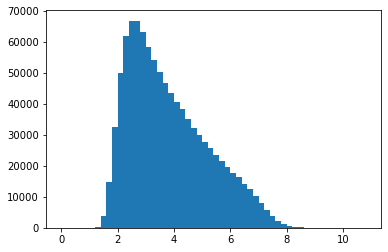

In [9]:
pl.hist(ecs, bins=np.arange(0,11,0.2))
print(np.percentile(ecs, (5,16,50,84,95)))

[1.26201873 1.50495029 1.99581524 2.77892816 3.44247373]


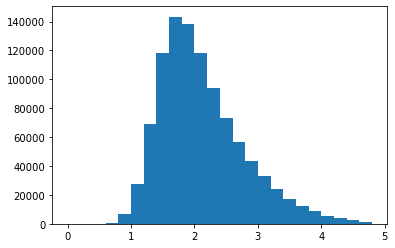

In [10]:
pl.hist(tcr, bins=np.arange(0,5,0.2))
print(np.percentile(tcr, (5,16,50,84,95)))

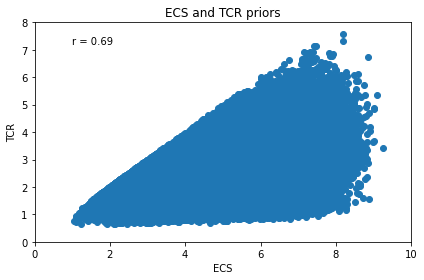

In [11]:
fig, ax = pl.subplots()
ax.scatter(ecs, tcr)
ax.text(0.1,0.9,'r = %.2f' % np.corrcoef(ecs,tcr)[0,1], transform=ax.transAxes)
ax.set_ylim(0,8)
ax.set_xlim(0,10)
ax.set_xlabel('ECS')
ax.set_ylabel('TCR')
ax.set_title('ECS and TCR priors')
fig.tight_layout()

In [12]:
print(np.percentile(ecs, (5,16,50,84,95)))
print(np.percentile(tcr, (5,16,50,84,95)))

[1.99189204 2.38898295 3.50688913 5.3810525  6.52317694]
[1.26201873 1.50495029 1.99581524 2.77892816 3.44247373]


## Forcing uncertainties

Ensure check the AR6 notebook #040

In [13]:
# these are standard deviations of the scale factor for normally distributed forcings (mean = 1). The list below is expressed in terms of 5-95% ranges.
unc_ranges = np.array([
    0.12,      # CO2
    0.20,      # CH4: updated value from etminan 2016
    0.14,      # N2O
    0.19,      # other WMGHGs
    0.50,      # Total ozone
    1.00,      # stratospheric WV from CH4
    0.70,      # contrails approx - half-normal
    1.25,      # bc on snow - half-normal
    0.50,      # land use change
    5.0/20.0,  # volcanic
    0.50,      # solar (amplitude)
])/NINETY_TO_ONESIGMA

NORMALS = len(unc_ranges)

scale_normals = st.norm.rvs(
    size=(SAMPLES,NORMALS),
    loc=np.ones((SAMPLES,NORMALS)),
    scale=np.ones((SAMPLES, NORMALS)) * unc_ranges[None,:],
    random_state=SEEDS[4]
)

## bc snow is asymmetric Gaussian. We can just scale the half of the distribution above/below best estimate
scale_normals[scale_normals[:,7]<1,7] = 0.06/0.1*(scale_normals[scale_normals[:,7]<1,7]-1) + 1

## so is contrails - the benefits of doing this are tiny :)
scale_normals[scale_normals[:,6]<1,6] = 0.0384/0.0406*(scale_normals[scale_normals[:,6]<1,6]-1) + 1

trend_solar = st.norm.rvs(size=SAMPLES, loc=+0.01, scale=0.07/NINETY_TO_ONESIGMA, random_state=SEEDS[50])

np.save('../data_input_large/fair-samples/scale_normals.npy', scale_normals)
np.save('../data_input_large/fair-samples/scale_trend_solar.npy', trend_solar)

### Aerosol emissions

check against #010, #040, #050

In [14]:
with open('../data_input/tunings/cmip6_aerosol_coefficients.json') as json_file:
    cmip6_aerosol_data = json.load(json_file)

In [15]:
cmip6_aci = np.zeros((11, 2))
for i, model in enumerate(['CanESM5', 'E3SM', 'GFDL-ESM4', 'GFDL-CM4', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'NorESM2-LM', 'UKESM1-0-LL']):
    for j, species in enumerate(['n0','n1']):
        cmip6_aci[i,j] = np.log(cmip6_aerosol_data[model]['ERFaci'][species])
kde = st.gaussian_kde(cmip6_aci.T)
aci_coeffs=np.exp(kde.resample(size=int(SAMPLES), seed=SEEDS[8]).T)

np.save('../data_input_large/fair-samples/aci_coeffs.npy', aci_coeffs)

In [16]:
# target ranges for aerosols:
# total ERFari -0.6 -0.3 -0.0
## BC 0.05 0.4 0.8 then subtract -0.1 for RA so -0.05 0.3 0.7
## SO2 -0.6 -0.4 -0.2
## OC -0.16 -0.09 -0.03
## Nitrate -0.3 -0.11 -0.03
bc_20101750 = st.norm.rvs(loc=0.3, scale=0.2/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[95])
oc_20101750 = st.norm.rvs(loc=-0.09, scale=0.07/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[96])
so2_20101750 = st.norm.rvs(loc=-0.4, scale=0.2/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[97])
nit_20101750 = st.norm.rvs(loc=-0.11, scale=0.05/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[98])

array([-0.59508118, -0.29988114, -0.00482923])

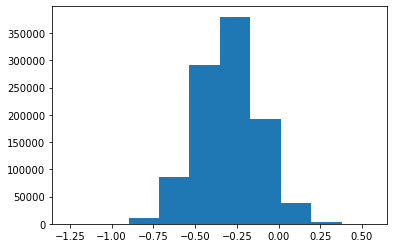

In [17]:
pl.hist(bc_20101750+oc_20101750+so2_20101750+nit_20101750)
np.percentile(bc_20101750+oc_20101750+so2_20101750+nit_20101750, (5,50,95))

In [18]:
# Get SSP historical emissions
ssp_df = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
species = [
    'Emissions|Sulfur',
    'Emissions|BC',
    'Emissions|OC',
    'Emissions|NH3',
    'Emissions|NOx'
]

unit_convert = np.ones(5)
unit_convert[0] = 32/64 # follow zeb exactly, but would be better to use fair.constants.molwt
unit_convert[4] = 14/46

emissions_out = np.zeros((351,5))

years_future = [2015] + list(range(2020,2101,10))
for i, specie in enumerate(species):
    emissions_out[:265,i] = ssp_df.loc[
        (ssp_df['Model']=='MESSAGE-GLOBIOM')&
        (ssp_df['Region']=='World')&
        (ssp_df['Scenario']=='ssp245')&
        (ssp_df['Variable']==specie),
        '1750':'2014']*unit_convert[i]
    f = interp1d(years_future, ssp_df.loc[
        (ssp_df['Model']=='MESSAGE-GLOBIOM')&
        (ssp_df['Region']=='World')&
        (ssp_df['Scenario']=='ssp245')&
        (ssp_df['Variable']==specie),'2015':'2100'
    ].dropna(axis=1))
    emissions_out[265:, i] = f(np.arange(2015, 2101))*unit_convert[i]

In [19]:
beta_bc = bc_20101750/(np.mean(emissions_out[255:265,1])-emissions_out[0,1])
beta_oc = oc_20101750/(np.mean(emissions_out[255:265,2])-emissions_out[0,2])
beta_so2 = so2_20101750/(np.mean(emissions_out[255:265,0])-emissions_out[0,0])
beta_nh3 = nit_20101750/(np.mean(emissions_out[255:265,3])-emissions_out[0,3])

### Testing and scaling aerosol emissions

In [20]:
ERFari = np.zeros((351, SAMPLES))
for i in range(SAMPLES):
    ERFari[:, i] = (
        (emissions_out[:,0]-emissions_out[0,0]) * beta_so2[i] +
        (emissions_out[:,1]-emissions_out[0,1]) * beta_bc[i] +
        (emissions_out[:,2]-emissions_out[0,2]) * beta_oc[i] +
        (emissions_out[:,3]-emissions_out[0,3]) * beta_nh3[i] 
        #        (emissions_out[:,4]-emissions_out[0,4]) * beta_nox[i]
    )

In [21]:
np.save('../data_input_large/fair-samples/beta_so2_unconstrained.npy', beta_so2)
np.save('../data_input_large/fair-samples/beta_bc_unconstrained.npy', beta_bc)
np.save('../data_input_large/fair-samples/beta_oc_unconstrained.npy', beta_oc)
np.save('../data_input_large/fair-samples/beta_nh3_unconstrained.npy', beta_nh3)

In [22]:
ERFaci_scale = st.norm.rvs(size=SAMPLES, loc=-1.0, scale=0.7/NINETY_TO_ONESIGMA, random_state=SEEDS[9])
# option here: use Smith et al 2020 ACP correlations in models and sample as joint normal. They are strongly anti-correlated.

In [23]:
#print(np.percentile(ERFari_scale, (5,16,50,84,95)))
print(np.percentile(ERFaci_scale, (5,16,50,84,95)))
#print(np.percentile(ERFari_scale+ERFaci_scale, (5,16,50,84,95)))

[-1.69913916 -1.42248834 -1.00051153 -0.57760861 -0.30205032]


In [24]:
#ERFari = np.zeros((270, SAMPLES))
ERFaci = np.zeros((351, SAMPLES))
beta   = np.zeros(SAMPLES)

for i in tqdm(range(SAMPLES)):
    forcing2010 = np.mean(
        ghan([
            emissions_out[255:265,0], emissions_out[255:265,1]+emissions_out[255:265,2]
        ], 0.97, aci_coeffs[i,0], aci_coeffs[i,1])
    )
    forcing1750 = ghan([emissions_out[0,0], emissions_out[0,1]+emissions_out[0,2]], 0.97, aci_coeffs[i,0], aci_coeffs[i,1])
    ERFaci[:,i] = (ghan([emissions_out[:,0], emissions_out[:,1]+emissions_out[:,2]], 0.97, aci_coeffs[i,0], aci_coeffs[i,1]) - forcing1750)/(forcing2010-forcing1750)*(ERFaci_scale[i])
    beta[i] = ERFaci_scale[i]/(forcing2010-forcing1750)
np.save('../data_input_large/fair-samples/beta_unconstrained.npy', beta)

In [25]:
np.percentile(ERFari[260,:]+ERFaci[260,:], (5,16,50,84,95))

array([-2.05711085, -1.75399445, -1.29033147, -0.82696466, -0.52477934])

## Carbon cycle parameters

Uniform distributions from Leach et al 2020 https://gmd.copernicus.org/preprints/gmd-2020-390/, using full range of CMIP6 tunings.

Pre-industrial CO2 concentration uncertainty is from Jinho Ahn, chapter 2 AR6 WG1. SHOULD WE USE AR6 VALUE WHICH IS SLIGHTLY DIFFERENT?

In [26]:
r0 = st.uniform.rvs(loc=27.7, scale=41.3-27.7, random_state=SEEDS[10], size=SAMPLES)
rC = st.uniform.rvs(loc=-0.00712, scale=0.0482+0.00712, random_state=SEEDS[11], size=SAMPLES)
rT = st.uniform.rvs(loc=-0.0847, scale=4.52+0.0847, random_state=SEEDS[12], size=SAMPLES)
pre_ind_co2 = st.norm.rvs(loc=277.147, scale=2.9, random_state=SEEDS[13], size=SAMPLES)

np.save('../data_input_large/fair-samples/r0_unconstrained.npy', r0)
np.save('../data_input_large/fair-samples/rC_unconstrained.npy', rC)
np.save('../data_input_large/fair-samples/rT_unconstrained.npy', rT)
np.save('../data_input_large/fair-samples/pre_ind_co2_unconstrained.npy', pre_ind_co2)

# I now think we have everything we need to run FaIR with

Before tackling the AR6-WG3 format, let's see how they look before we let this loose on the world.

In [27]:
#ssp_df = pd.read_csv(os.path.join(os.path.dirname(fair.__file__), 'SSPs/data/rcmip-emissions-annual-means-4-0-0-ssp-only.csv'))
ssp_df = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')

In [28]:
years = np.arange(1750,2101)
startyear = 1750
first_scenyear = 2015
last_scenyear = 2100
first_row = int(first_scenyear-startyear)
last_row = int(last_scenyear-startyear)

species = [  # in fair 1.6, order is important
    '|CO2|MAGICC Fossil and Industrial',
    '|CO2|MAGICC AFOLU',
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|CF4',
    '|C2F6',
    '|C6F14',
    '|HFC23',
    '|HFC32',
    '|HFC4310mee',
    '|HFC125',
    '|HFC134a',
    '|HFC143a',
    '|HFC227ea',
    '|HFC245fa',
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

# Assume that units coming out of aneris don't change. One day I'll do unit parsing
unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

data_out = {}

scens = ['ssp245']
for scen in scens:
    data_out[scen] = np.ones((351, 40)) * np.nan
    data_out[scen][:,0] = years

    years_future = [2015] + list(range(2020,2101,10))
    for i, specie in enumerate(species):
        data_out[scen][:first_row,i+1] = ssp_df.loc[(ssp_df['Model']=='MESSAGE-GLOBIOM')&(ssp_df['Region']=='World')&(ssp_df['Scenario']==scen)&(ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
        f = interp1d(years_future, ssp_df.loc[(ssp_df['Model']=='MESSAGE-GLOBIOM')&(ssp_df['Region']=='World')&(ssp_df['Scenario']==scen)&(ssp_df['Variable'].str.endswith(specie)),'2015':'2100'].dropna(axis=1))
        data_out[scen][first_row:(last_row+1), i+1] = f(np.arange(first_scenyear, last_scenyear+1))*unit_convert[i+1]

In [29]:
data_out['ssp245'].shape

(351, 40)

In [30]:
data_out['ssp245'][250,:]

array([2.00000000e+03, 6.88899310e+00, 1.20061057e+00, 3.10186810e+02,
       6.11111906e+00, 5.55743021e+01, 8.86564730e+02, 1.95324158e+02,
       4.12492764e+01, 7.45734723e+00, 2.79819784e+01, 5.45095965e+01,
       9.92314570e+00, 2.81539430e+00, 8.27090430e-01, 9.29783890e+00,
       1.41149200e+00, 5.74232780e-01, 1.06406670e+01, 9.96574240e+01,
       8.59875630e+00, 8.63199880e-01, 3.40069260e-02, 5.27353320e+00,
       7.63300760e+01, 1.22766050e+02, 9.40438840e+00, 3.98671420e+00,
       2.34765180e+00, 7.26514080e+01, 1.94712270e+01, 2.63606270e+02,
       5.63416860e+01, 2.57301520e+01, 9.48013480e+00, 0.00000000e+00,
       1.96944120e+00, 7.71519220e-01, 1.65258760e+02, 5.07426960e+03])

In [31]:
# add in natural emissions and natural forcing
ch4_n2o_df = pd.read_csv('../data_output/fair_wg3_natural_ch4_n2o.csv')
ch4_n2o = ch4_n2o_df.values[:351,1:]

df = pd.read_csv('../data_output/solar_erf.csv', index_col='year')
solar_forcing = df.solar_erf.loc[1750:2100].values

df = pd.read_csv('../data_output/volcanic_erf.csv', index_col='year')
volcanic_forcing = np.zeros((351))
volcanic_forcing[:269] = df.volcanic_erf.loc[1750:2018].values
# ramp down last 10 years to zero according to https://www.geosci-model-dev.net/9/3461/2016/gmd-9-3461-2016.html
volcanic_forcing[268:279] = volcanic_forcing[268] * np.linspace(1,0,11)
volcanic_forcing[279:] = 0.

In [32]:
trend_solar.shape

(1000000,)

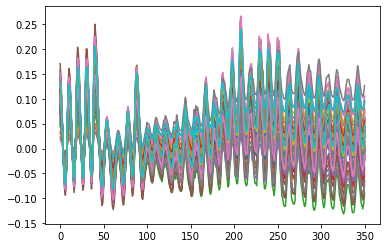

In [33]:
for i in range(100):
    F_solar = np.zeros(351)
    F_solar[:270] = np.linspace(0,trend_solar[i],270) + solar_forcing[:270]*scale_normals[i,10]
    F_solar[270:351] = trend_solar[i] + solar_forcing[270:351]*scale_normals[i,10]
    pl.plot(F_solar)

In [34]:
o3_df = pd.read_csv('../data_input/tunings/cmip6_ozone_skeie_fits.csv', index_col=0)
o3_df#.loc['NMVOC','mean']

,mean,u90
species,,
CH4,2.333797e-04,0.000062
N2O,1.271791e-03,0.000471
ODS,-6.693478e-05,-0.000113
CO,1.146477e-04,0.000131
NMVOC,5.143661e-12,0.000328
NO2,1.151513e-03,0.000983


In [35]:
ozone_feedback = st.norm.rvs(loc=-0.037, scale=0.012, size=SAMPLES, random_state=SEEDS[51])
# these coefficients are AerChemMIP - don't delete for now
#beta_ch4 = st.norm.rvs(loc=0.00017380181731885394, scale=6.207207761387641e-05/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[52])
#beta_n2o = st.norm.rvs(loc=0.0007061379618263551, scale=0.0004707586412175701/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[53])
#beta_ods = st.norm.rvs(loc=-0.00012432206866394785, scale=0.00011302006242177078/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[54])
#beta_co = st.norm.rvs(loc=0.00015401820093350843, scale=0.00013103040974940267/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[55])
#beta_voc = st.norm.rvs(loc=0.00032758074092083077, scale=0.00032758074092083077/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[56])
#beta_nox = st.norm.rvs(loc=46/14*0.0017868021851642044, scale=46/14*0.0009827412018403123/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[57])

# these coefficients are Skeie fits
beta_ch4 = st.norm.rvs(loc=o3_df.loc['CH4','mean'], scale=o3_df.loc['CH4','u90']/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[52])
beta_n2o = st.norm.rvs(loc=o3_df.loc['N2O','mean'], scale=o3_df.loc['N2O','u90']/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[53])
beta_ods = st.norm.rvs(loc=o3_df.loc['ODS','mean'], scale=-o3_df.loc['ODS','u90']/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[54])
beta_co = st.norm.rvs(loc=o3_df.loc['CO','mean'], scale=o3_df.loc['CO','u90']/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[55])
beta_voc = st.norm.rvs(loc=o3_df.loc['NMVOC','mean'], scale=o3_df.loc['NMVOC','u90']/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[56])
beta_nox = st.norm.rvs(loc=46/14*o3_df.loc['NO2','mean'], scale=46/14*o3_df.loc['NO2','u90']/NINETY_TO_ONESIGMA, size=SAMPLES, random_state=SEEDS[57])
    
np.save('../data_input_large/fair-samples/ozone_feedback_unconstrained.npy', ozone_feedback)
np.save('../data_input_large/fair-samples/beta_ch4_unconstrained.npy', beta_ch4)
np.save('../data_input_large/fair-samples/beta_n2o_unconstrained.npy', beta_n2o)
np.save('../data_input_large/fair-samples/beta_ods_unconstrained.npy', beta_ods)
np.save('../data_input_large/fair-samples/beta_co_unconstrained.npy', beta_co)
np.save('../data_input_large/fair-samples/beta_voc_unconstrained.npy', beta_voc)
np.save('../data_input_large/fair-samples/beta_nox_unconstrained.npy', beta_nox)